# loadest-gp
LOAD ESTimator (LOADEST) is a software program for estimating some constituent using surrogate variables (covariates).
However, LOADEST has several serious limitations, and it has been all but replaced by another model known as WRTDS.
`loadest-gp` essentially reimplements WRTDS as a Gaussian process.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/discontinuum/blob/main/notebooks/loadest-gp-demo.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/thodson-usgs/discontinuum/main?labpath=notebooks%2Floadest-gp-demo.ipynb)

In [1]:
# install the latest version of discontinuum
!pip install git+https://github.com/thodson-usgs/discontinuum.git

  Cloning https://github.com/thodson-usgs/discontinuum.git to /private/var/folders/zr/jc46d6cs531df81bpgj4681sz25hhs/T/pip-req-build-eph7bw_7
  Running command git clone --filter=blob:none --quiet https://github.com/thodson-usgs/discontinuum.git /private/var/folders/zr/jc46d6cs531df81bpgj4681sz25hhs/T/pip-req-build-eph7bw_7
  Resolved https://github.com/thodson-usgs/discontinuum.git to commit 921db8f19ff57fe41db8ff93a43f5ac44e7c3dea
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pymc-5.15.0-py3-none-any.whl.metadata (10 kB)
  Using cached xarray-2024.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached arviz-0.18.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.

In [2]:
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

In [3]:
# setup

# SF Coeur D Alene River 
site = "12413470"
start_date = "1988-10-01" 
end_date = "2021-09-30" 

# Choptank River at Greensboro, MD
#site = "01491000" 
#start_date = "1979-10-01"
#end_date = "2011-09-30"

characteristic = 'Inorganic nitrogen (nitrate and nitrite)'
fraction = 'Dissolved'

First, download the data. In `discontinuum`, the convention is to download directly using `providers`, which wrap a data provider's web-service and perform some initial formatting and metadata construction, then return the result as an `xarray.Dataset`. Here, we'll uses the `usgs` provider. If you need data from another source, create a `provider` and ensure the output matches that of the `usgs` provider. Here, we'll download some daily streamflow data to use as our model's input, and some concentration samples as our target. 

In [4]:
from loadest_gp.providers import usgs

# download covariates (daily streamflow)
daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)

# download target (concentration)
samples = usgs.get_samples(site=site, 
                           start_date=start_date, 
                           end_date=end_date, 
                           characteristic=characteristic, 
                           fraction=fraction)

samples

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(


<xarray.Dataset> Size: 4kB
Dimensions:        (time: 227)
Coordinates:
  * time           (time) datetime64[ns] 2kB 1989-11-20T14:00:00 ... 2021-09-...
Data variables:
    concentration  (time) float64 2kB 0.29 0.1 0.3 0.2 ... 0.09 0.1 0.06 0.31
Attributes:
    id:         12413470
    name:       SF Coeur D Alene River nr Pinehurst, ID
    latitude:   47.5513111
    longitude:  -116.2362917

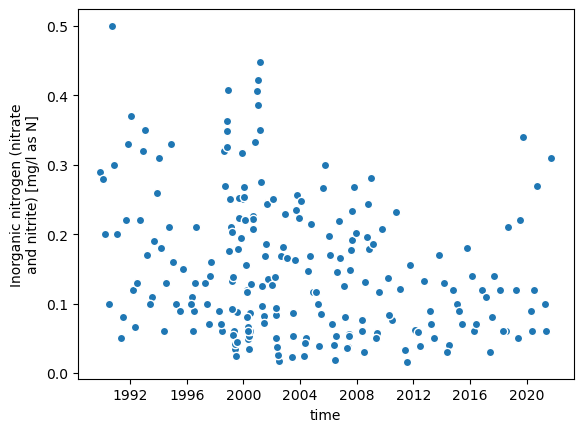

In [5]:
samples.plot.scatter(x='time', y='concentration')

Next, perpare the training data by preforming an inner join of the target and covarites.

In [6]:
from discontinuum.utils import aggregate_to_daily

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join='inner')

Now, we're ready to fit the model. Depending on your hardware, this can take seconds to several minutes. The first fit will also compiles the model, which takes longer. After running it once, try running the cell again and note the difference in wall time.

In [ ]:
%%time
from loadest_gp import LoadestGP

model = LoadestGP()

model.fit(target=training_data['concentration'], covariates=training_data[['time','flow']])

In [ ]:
# plot result
model.plot(daily[['time','flow']])

Like WRTDS, we can also plot the variable space:

In [ ]:
model.contourf(levels=5, y_scale='log')

For plotting, we don't need to simulate the full covariance matrix. Instead, we can use its diagonal to compute confidence intervals, but for most other uses, we need to simulate predictions using full covariance, which is slower. Here, we simulate daily concentration during 1990-2020, then we will use those simulations to estimate annual fluxes with uncertainty.

In [ ]:
# simulate concentration
sim_slice = daily[['time','flow']].sel(time=slice("1990","2020"))

sim = model.sample(sim_slice)

In [ ]:
# plot the first realization of concentration. 
sim.sel(draw=0).plot.line(x='time')

Before using this simulation, create helper functions to compute flux and plot the results.

In [ ]:
# helper functions to compute flux and plot annual fluxes
def to_flux(concentration, flow):
    """Convert concentration and daily mean flow to flux"""
    flux = concentration * flow * 86400 * 1e-6
    flux.attrs = sim.attrs
    flux.attrs['units'] = 'kilograms per day'
    flux.attrs['standard_name'] = 'flux'
    return flux

def plot_annual_sum(sim):
    """Describe
    """
    fig, ax = plt.subplots()
    annual = sim.resample(time='YE').sum()
    annual.attrs['units'] = 'kilograms per year'

    
    annual.to_dataframe(name=annual.attrs['standard_name']).boxplot(by='time', showfliers=False, grid=False, ax=ax)
    ax.set_ylabel('{}\n[{}]'.format(annual.attrs['long_name'], annual.attrs['units']))
    ax.set_xlabel('Year')
    ax.tick_params(axis='x', labelrotation=90)

    labels = ['' if (year % 5 != 0) else year for i, year in enumerate(annual.time.dt.year.values)]
    ax.set_xticklabels(labels)
    ax.set_title('')
    #fig.suptitle('')
    return ax

Using the helpers, compute and plot the annual flux.

In [ ]:
flux = to_flux(sim, sim_slice['flow'])
plot_annual_sum(flux)

In most streams, flow varies substantially from year-to-year, 
and we'd like to know what the flux might have been had flow been constant. 
In causal paralance, this is refered to as a [counterfactual](https://en.wikipedia.org/wiki/Counterfactual_conditional). 
However,`loadest_gp` isn't a causal model and can't provide us with counterfactuals. 
In other words, it can interpolate but not extrapolate. 
Nevertheless, we may treat is as such causal model and see what happens.
Think of this type of analysis as a pseudo-counterfactual or educated guessing.
There area variety of strategies that we might employee, 
some more sophisticated then others. 
At the end of the day, remember we're only guessing, 
so keep it simple and don't be tempted into over-interpretation.
Here, we'll use a simple time substitution.
Pick one year's worth of data and repeat it (except for the time variable) over the entire period of analysis.
For example, let's repeat the year 2005 to fill in the data for our 1990-2020 in our counterfactual.
What's special about 2005?
Nothing, except that it is at the middle of our period.

In [ ]:
# create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("2005","2005"))

In [ ]:
# simulate
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = to_flux(counterfactual_sim, sim_slice['flow'])

In [ ]:
# and plot the result
plot_annual_sum(counterfactual_sim)

Observer how the annual fluxes are much less variable than before